In [226]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

from sklearn import svm, metrics
from sklearn.model_selection import GridSearchCV

# Task 2.1

In [227]:
#defines function used in one step algorithm with function input a vector z
def SVMfunc(z, x, y, beta, bias):
    return bias + sum([beta[l]*y[l]*np.dot(z, x[l]) for l in range(len(beta))])

def SVMfunc2(z, x, y, beta, bias):
    ans=bias+(y*(z@x.T))@beta
    return(ans)

In [228]:
def OneStep(i,j, x, y, beta, bias, C):
    delta = y[i]*((SVMfunc(x[j], x, y, beta, bias)-y[j]) - (SVMfunc(x[i], x, y, beta, bias) - y[i]))
    s = y[i]*y[j]
    chi = np.dot(x[i],x[i]) + np.dot(x[j],x[j]) - 2*np.dot(x[i],x[j])
    gamma = s*beta[i] + beta[j]
    
    if s==1:
        L= max(0, gamma - C)
        H = min(gamma, C)
    
    else:
        L = max(0, -1*gamma)
        H = min(C, C-gamma)
    
    if chi>0:
        beta[i] = min(max(beta[i] + delta/chi, L), H)
    elif delta > 0:
        beta[i] = L
    else:
        beta[i] = H
    beta[j] = gamma - s * beta[i]
    bias = bias - 0.5 * (SVMfunc(x[j], x, y, beta, bias) - y[j] + SVMfunc(x[i], x, y, beta, bias) - y[i])
    return (beta, bias)
        

# Task 2.2

In [229]:
#draws test data according to exponential distribution and labels scale1 points with -1 and scale 2 points with 1
def expTestData(SampleSize, scale1, scale2):
    #draw SampleSize by 2 points according to exp distribution with lambda =4,0.5 resp.
    x1 = np.random.exponential(scale=scale1, size = (SampleSize,2))
    x2 = np.random.exponential(scale=scale2, size = (SampleSize,2))

    #label points in x1 by -1 and points in x2 by 1
    y2 = np.ones(SampleSize)
    y1 = np.full(SampleSize, -1)

    #join all data points into x matrix and y matrix
    x = np.concatenate((x1, x2), axis =0)
    y = np.concatenate((y1, y2), axis=0)
    
    return(x,y)

x_train, y_train = expTestData(20, 0.25, 2)

# Task 2.3

In [230]:
#SMO algorithm from part (a)
def SMO(x, y, iterations, C):
    n = len(x)
    beta = np.zeros(n)
    bias = 0
    
    for k in range(iterations):
        #picks two non equal integers from 0 to n
        i, j = np.random.choice(n, 2)
        
        #updates beta and bias according to onestep algorithm
        beta, bias = OneStep(i,j, x, y, beta, bias, C)

    s=(SVMfunc2(x,x,y,beta,bias)-y)[beta!=0]
    bias=bias-np.median(s)
    
    return(beta, bias)

Running SMO algorithm for different values of C

In [231]:
#SMO run for C = 0.01
beta1, bias1 =SMO(x_train, y_train, 10000, 0.01)

#SMO run for C = 1
beta2, bias2 =SMO(x_train, y_train, 10000, 1)

#SMO run for C = 100
beta3, bias3 =SMO(x_train, y_train, 10000, 100)

Defining functions to help with contour plots

In [232]:
#Given a function func, gives the contour plot with hyperplane corresponding to func = value
def conplot(func, value, maxx, minx, maxy, miny):
 
    #create meshgrid using the given min and max x,y values
    t = np.arange(minx-1, maxx+1, 0.1)
    s = np.arange(miny-1, maxy+1, 0.1)
    p,q = np.meshgrid(t, s)
    
    funcArgs = np.array([p.flatten(), q.flatten()]).T
    r = func(funcArgs)
    r= np.reshape(r, p.shape)
    
    plt.contourf(t,s,r,[-99999,value,99999], colors=['blue','red'],alpha=0.2)

In [233]:
def SMO_conplot(beta, C, func):
    z1=x_train[beta>0]
    print('number of support vectors is ', len(z1))
    z2=x_train[np.logical_and(beta>0, beta1<C)]
    print('number of margin vectors is ', len(z2))
    
    maxx = np.max(x_train[:,0])
    maxy = np.max(x_train[:,1])
    minx = np.min(x_train[:,0])
    miny = np.min(x_train[:,1])

    conplot(func, 0, maxx, minx, maxy, miny)
    plt.scatter(z1[:,0], z1[:,1], label = 'support vectors', color = 'black', marker = 'D')
    plt.scatter(x_train[:20,0], x_train[:20,1], label = '-1', alpha = 0.7)
    plt.scatter(x_train[20:,0], x_train[20:,1], label = '1', color = 'red', alpha = 0.7)
    plt.scatter(z2[:,0], z2[:,1], label = 'margin vectors', color = 'black', marker = 'x')
    plt.legend()

Showing contour plots for the different values of C

number of support vectors is  39
number of margin vectors is  0


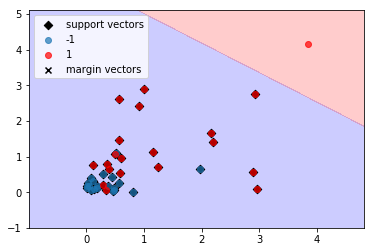

In [234]:
#Gives hyperplane for C=0.01
def funcPlot1(z):
    return SVMfunc(z, x_train, y_train, beta1, bias1)

SMO_conplot(beta1, 0.01, funcPlot1)

number of support vectors is  20
number of margin vectors is  20


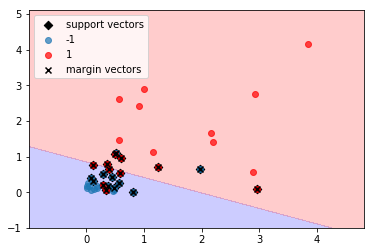

In [235]:
#Gives hyperplane for C=1
def funcPlot2(z):
    return SVMfunc(z, x_train, y_train, beta2, bias2)

SMO_conplot(beta2, 1, funcPlot2)

number of support vectors is  13
number of margin vectors is  13


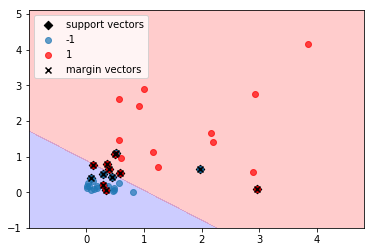

In [236]:
#Gives hyperplane for C=100
def funcPlot3(z):
    return SVMfunc(z, x_train, y_train, beta3, bias3)

SMO_conplot(beta3, 100, funcPlot3)

In [237]:
# Solve LLS (copied from Sheet 1)
# returns coefficients for classifiying line a_0x_0 + ... + a_(d-1)x_(d-1) + a_d = 0.5
def LLS(X): #X a (n,d) numpy array with d-1 dependent variables and 1 independent variable
    n = X.shape[0]
    d = X.shape[1]
    X = np.insert(X,d-1,1,axis=1) # add column of 1s for constant term
    x = X[:,0:d] # dependent variable
    y = X[:,d] # independent variable
    y=y.reshape(n,1)
    c=x.T@x
    return(np.linalg.solve(c,x.T@y)) 

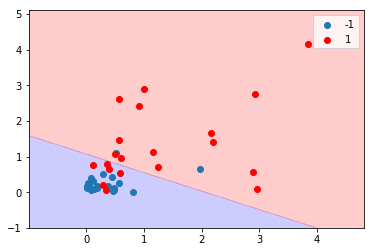

In [238]:
#run LLS on our data (must concatenate the x data with the y labels to use function)
X = np.concatenate((x_train, y_train.reshape((len(y_train), 1))), axis = 1)
alpha = LLS(X).flatten()

#define LLS function to give to conplot
def funcLLS(z):
    return np.dot(z,alpha[:2].reshape((2,1)))

maxx = np.max(x_train[:,0])
maxy = np.max(x_train[:,1])
minx = np.min(x_train[:,0])
miny = np.min(x_train[:,1])

conplot(funcLLS, 0.5, maxx, minx, maxy, miny)
plt.scatter(x_train[:20,0], x_train[:20,1], label = '-1')
plt.scatter(x_train[20:,0], x_train[20:,1], label = '1', color = 'red')
plt.legend()

As C grows the fit of the separating hyperplane becomes better. The number of margin vectors increase, where as the number of support vectors decrease. Comparing this to LLS, for larger C the SMO function gives a better fit than LLS.

# Task 2.4

In [245]:
x_testdata, y_testdata = expTestData(1000, 0.25, 2)

In [246]:
#function for confusion matrix and accuracy
def confusion(y_real, y_guess):
    C10=np.sum(np.logical_and([y_guess>0],y_real==-1))
    C00=np.sum(np.logical_and([y_guess<=0],y_real==-1))
    C01=np.sum(np.logical_and([y_guess<=0],y_real==1))
    C11=np.sum(np.logical_and([y_guess>0],y_real==1))
    C=[[C00,C01],[C10,C11]]
    print("Confusion matrix: ", C)
    print("accuracy: " , np.trace(C)/len(y_real))
    return(C)

In [248]:
#confusion matrix and accuracy for C=0.01
y_1 = funcPlot1(x_testdata)
confusion(y_testdata, y_1)



Confusion matrix:  [[1000, 817], [0, 183]]
accuracy:  0.5915


[[1000, 817], [0, 183]]

In [249]:
#confusion matrix and accuracy for C=1
y_2 = funcPlot2(x_testdata)
confusion(y_testdata, y_2)

Confusion matrix:  [[938, 129], [62, 871]]
accuracy:  0.9045


[[938, 129], [62, 871]]

In [252]:
#confusion matrix and accuracy for C=100
y_3 = funcPlot3(x_testdata)
confusion(y_testdata, y_3)

Confusion matrix:  [[893, 85], [107, 915]]
accuracy:  0.904


[[893, 85], [107, 915]]

In [253]:
#confusion matrix for LLS (copied from last sheet)
X = np.concatenate((x_testdata, y_testdata.reshape((len(y_testdata), 1))), axis = 1)
print(X.shape)
alpha = LLS(X)

n=X.shape[0]
d=X.shape[1]-1
Xevaled = X[:,0:d].dot(alpha[0:d,0])+alpha[d,0]
C10=np.sum(np.logical_and([Xevaled>0.5],X[:,d]==-1))
C00=np.sum(np.logical_and([Xevaled<0.5],X[:,d]==-1))
C01=np.sum(np.logical_and([Xevaled<0.5],X[:,d]==1))
C11=np.sum(np.logical_and([Xevaled>0.5],X[:,d]==1))
C=[[C00,C01],[C10,C11]]
print("Confusion matrix: ", C)
print("accuracy: " , np.trace(C)/n)

(2000, 3)
Confusion matrix:  [[1000, 628], [0, 372]]
accuracy:  0.686


# Task 2.5

In [254]:
def KKT(i, x, y, beta, C, bias):
    return (C - beta[i])*max(0, 1 - y[i]*SVMfunc(x[i], x, y, beta, bias)) + beta[i]*max(0, y[i]*SVMfunc(x[i], x, y, beta, bias)-1)>0

In [255]:
def SMO_KKT(x, y, iterations, C):
    n = len(x)
    beta = np.zeros(n)
    bias = 0
    k=0
    terminate = True
    
    #array of elements i such that KKT(i)>0
    b = [i for i in range(n) if KKT(i, x, y, beta, C, bias)]
    
    #if there are no such elements, return false
    if len(b)==0:
        print('no i such that KKT(i)>0')
        return false
   
    #array of elements j such that 0<beta[j]<c
    a = np.arange(n)
    c = a[np.logical_and(beta>0, beta<C)]
    
    #if no elements satisfy j condition above, then we allow any j from 0 to n
    if len(c) == 0:
        c = a
        
    while k < iterations:
        terminate = True
        for i in [l for l in range(n) if KKT(l, x, y, beta, C, bias)]:
            #choose j either satisfiying 0<beta[j]<c or, if not possible, 1<j<n such that j!=i
            j = np.random.choice(c[c!=i])
            #updates beta and bias according to onestep algorithm
            beta, bias = OneStep(i,j, x, y, beta, bias, C)
            k=k+1
            terminate = False
        if terminate == True:
            break

    suppVecInd = np.array([SVMfunc(x[k], x, y, beta, bias) - y[k] for k in np.nonzero(beta)])
    bias = bias - np.median(suppVecInd)
    
    return(beta, bias)

In [257]:
#SMO_KKT run for C = 0.01
beta1, bias1 =SMO_KKT(x_train, y_train, 10000, 0.01)

#SMO_KKT run for C = 1
beta2, bias2 =SMO_KKT(x_train, y_train, 10000, 1)

#SMO_KKT run for C = 100
beta3, bias3 =SMO_KKT(x_train, y_train, 10000, 100)

In [258]:
def funcPlot1(z):
    return SVMfunc(z, x_train, y_train, beta1, bias1)

def funcPlot2(z):
    return SVMfunc(z, x_train, y_train, beta2, bias2)

def funcPlot3(z):
    return SVMfunc(z, x_train, y_train, beta3, bias3)


number of support vectors is  40
number of margin vectors is  0


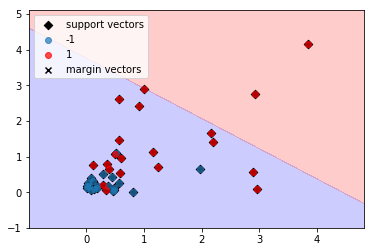

In [259]:
SMO_conplot(beta1, 0.01, funcPlot1)

number of support vectors is  20
number of margin vectors is  20


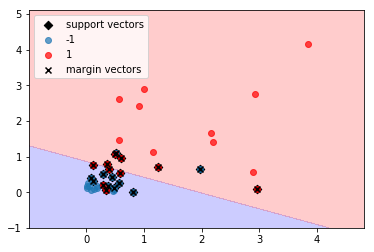

In [260]:
SMO_conplot(beta2, 1, funcPlot2)

number of support vectors is  17
number of margin vectors is  17


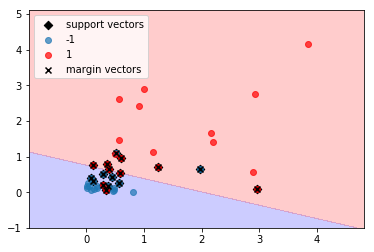

In [261]:
SMO_conplot(beta3, 100, funcPlot3)

Confusion matrices and accuracy for different C's using KKT

In [262]:
#confusion matrix and accuracy for C=0.01
y_1 = funcPlot1(x_testdata)
confusion(y_testdata, y_1)

Confusion matrix:  [[1000, 608], [0, 392]]
accuracy:  0.696


[[1000, 608], [0, 392]]

In [263]:
#confusion matrix and accuracy for C=1
y_2 = funcPlot2(x_testdata)
confusion(y_testdata, y_2)

Confusion matrix:  [[942, 130], [58, 870]]
accuracy:  0.906


[[942, 130], [58, 870]]

In [264]:
#confusion matrix and accuracy for C=100
y_3 = funcPlot3(x_testdata)
confusion(y_testdata, y_3)

Confusion matrix:  [[925, 117], [75, 883]]
accuracy:  0.904


[[925, 117], [75, 883]]

Using the KKT algorithm instead of random i, j does not seem to change the accuracy of the results - sometimes using KKT is marginally better, sometimes marginally worse. The run time for random i,j was quicker.

# Task 2.6

In [215]:
def conplot(x,y,iterations,C):
    beta,bias=SMO(x,y,iterations,C)
    
    maxx = np.amax(x[:,0])
    maxy = np.amax(x[:,1])
    minx = np.amin(x[:,0])
    miny = np.amin(x[:,1])    
    t = np.arange(minx-1, maxx+1, 0.1)
    s = np.arange(miny-1, maxy+1, 0.1)
    p,q = np.meshgrid(t, s)
    z = SVMfunc2(np.stack((p,q), axis=2),x,y,beta,bias)
    plt.contourf(t,s,z,[-99999,0,99999], colors=['blue','red'],alpha=0.5)
    plt.plot(x[y==-1][:,0],x[y==-1][:,1],'bo',x[y==1][:,0],x[y==1][:,1],'ro')

def conplot3(x,y,iterations,C):
    beta,bias=SMO(x,y,iterations,C)
    
    maxx = np.amax(x[:,0])
    maxy = np.amax(x[:,1])
    minx = np.amin(x[:,0])
    miny = np.amin(x[:,1])    
    t = np.arange(minx-1, maxx+1, 0.1)
    s = np.arange(miny-1, maxy+1, 0.1)
    p,q = np.meshgrid(t, s)
    z = SVMfunc2(np.stack((p,q,p**2+q**2), axis=2),x,y,beta,bias)
    plt.contourf(t,s,z,[-99999,0,99999], colors=['blue','red'],alpha=0.5)
    plt.plot(x[y==-1][:,0],x[y==-1][:,1],'bo',x[y==1][:,0],x[y==1][:,1],'ro')

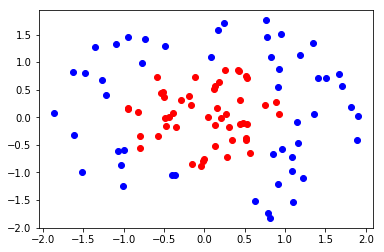

In [216]:
# create data, take a uniform distribution on [0,1]x[0,2\pi], scale 1st coord by sqrt( to get uniform dist on disk) and map to circle using polar coords

n= 50 #number of samples
x= np.random.uniform(0,1,n)
x=x**0.5
y= np.random.uniform(0,2*np.pi,n)
yd=x*np.sin(y)
xd=x*np.cos(y)
X1= np.vstack((xd,yd)).T
X1lbl=-1*np.ones(n)

#similarly for annulus
x= np.random.uniform(1,4,n)
x=x**0.5
y= np.random.uniform(0,2*np.pi,n)
yd=x*np.sin(y)
xd=x*np.cos(y)
X2= np.vstack((xd,yd)).T
X2lbl=np.ones(n)
#label X1 by -1 and X2 by 1


X_Data = np.concatenate((X1,X2))
Y_Data = np.concatenate((X1lbl,X2lbl))

plt.plot(X_Data[Y_Data==-1][:,0],X_Data[Y_Data==-1][:,1],'ro',X_Data[Y_Data==1][:,0],X_Data[Y_Data==1][:,1],'bo')

#circle1=plt.Circle((0,0),2,color='g')
#plt.gcf().gca().add_artist(circle1)
#circle2=plt.Circle((0,0),1,color='y')
#plt.gcf().gca().add_artist(circle2)
plt.show()

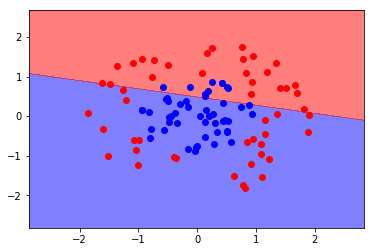

In [217]:
conplot(X_Data,Y_Data,100,10)
plt.show()

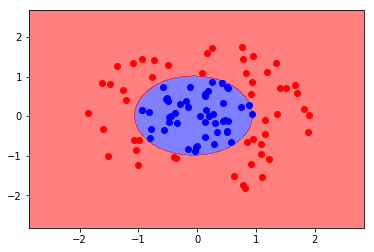

In [218]:
X_Trans = np.stack((X_Data[:,0],X_Data[:,1],X_Data[:,0]**2+X_Data[:,1]**2)).T

conplot3(X_Trans,Y_Data,100,10)
plt.show()

The map $\phi$ maps to a parabaloid. It adds the 2-norm of points as a parameter and this easily disinguishes the two data sets.

# Task 2.7

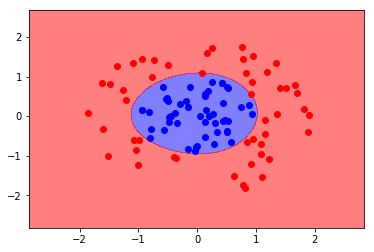

In [219]:
def SVMfunc_NL(z, x, y, beta, bias, kernel):
    ans=bias+(y*(kernel(z,x)))@beta
    return(ans)

def OneStep_NL(i,j, x, y, beta, bias, C,kernel):
    delta = y[i]*((SVMfunc_NL(x[j], x, y, beta, bias,kernel)-y[j]) - (SVMfunc_NL(x[i], x, y, beta, bias,kernel) - y[i]))
    s = y[i]*y[j]
    chi = kernel(x[i],x[i]) + kernel(x[j],x[j]) - 2*kernel(x[i],x[j])
    gamma = s*beta[i] + beta[j]
    
    if s==1:
        L= max(0, gamma -1*C)
        H = min(gamma, C)
    
    else:
        L = max(0, -1*gamma)
        H = min(C, C-gamma)
    
    if chi>0:
        beta[i] = min(max(beta[i] + delta/chi, L), H)
    elif delta > 0:
        beta[i] = L
    else:
        beta[i] = H
        
    beta[j] = gamma - s * beta[i]
    bias = bias - 0.5 * (SVMfunc_NL(x[j], x, y, beta, bias, kernel) - y[j] + SVMfunc_NL(x[i], x, y, beta, bias,kernel) - y[i])
    return (beta, bias)


def SMO_NL(x, y, iterations, C,kernel):
    n = len(x)
    beta = np.zeros(n)
    bias = 0
    
    for k in range(iterations):
        #picks two non equal integers from 0 to n
        i, j = np.random.choice(n, 2)
        
        #updates beta and bias according to onestep algorithm
        beta, bias = OneStep_NL(i,j, x, y, beta, bias, C,kernel)
    
    s=(SVMfunc_NL(x,x,y,beta,bias,kernel)-y)[beta!=0]
    bias=bias-np.median(s)
    
    return (beta,bias)

def norm(x):
    return np.sum(x*x,axis=len(x.shape)-1)
    
def GaussKernel(z,x,sigma):
    xt=x.reshape(tuple(np.ones(len(z.shape)-1).astype(int))+x.shape)
    zt=z.reshape(z.shape[:-1]+(1,)+(z.shape[-1],))  
    return np.exp(-norm(zt-xt)/(2*sigma**2))

def ScalarProdKernel(z,x):
    return z@x.T

def Gauss1(z,x):
    return GaussKernel(z,x,1)

def conplot_NL(x,y,iterations,C,kernel):
    beta,bias=SMO_NL(x,y,iterations,C,kernel)
    
    maxx = np.amax(x[:,0])
    maxy = np.amax(x[:,1])
    minx = np.amin(x[:,0])
    miny = np.amin(x[:,1])    
    t = np.arange(minx-1, maxx+1, 0.1)
    s = np.arange(miny-1, maxy+1, 0.1)
    p,q = np.meshgrid(t, s)
    z = SVMfunc_NL(np.stack((p,q), axis=2),x,y,beta,bias,kernel)
    plt.contourf(t,s,z,[-99999,0,99999], colors=['blue','red'],alpha=0.5)
    plt.plot(x[y==-1][:,0],x[y==-1][:,1],'bo',x[y==1][:,0],x[y==1][:,1],'ro')
    
conplot_NL(X_Data,Y_Data,1000,10,Gauss1)
plt.show()

# Task 2.8

In [220]:
#Load MNIST Data
import os
import gzip
from urllib.request import urlretrieve

def download(filename , source='http://yann.lecun.com/exdb/mnist/'):
    print("Downloading %s" % filename)
    urlretrieve (source + filename , filename)
    

def load_mnist_images (filename):
    if not os.path.exists(filename ):
        download(filename)
    with gzip.open(filename , 'rb') as f:
        data = np. frombuffer (f.read (), np.uint8 , offset=16)
    data = data.reshape (-1, 28, 28)
    return data / np.float32 (256)

def load_mnist_labels (filename):
    if not os.path.exists(filename ):
        download(filename)
    with gzip.open(filename , 'rb') as f:
        data = np. frombuffer (f.read (), np.uint8 , offset=8)
    return data

X_train = load_mnist_images('train-images-idx3-ubyte.gz')
y_train = load_mnist_labels('train-labels-idx1-ubyte.gz')
X_test = load_mnist_images('t10k-images-idx3-ubyte.gz')
y_test = load_mnist_labels('t10k-labels-idx1-ubyte.gz')


In [221]:
def Sample(n,X,Y):
    TrainSize=np.size(Y)
    Choice=np.random.choice(TrainSize,n)
    return (X[Choice,:],Y[Choice])
    
def CrossValidation(X_train,y_train):
    X_validate,y_validate=Sample(500,X_train,y_train)
    
    para= {'C':[1,10,100], 'gamma':[0.1,0.01,0.001]}
    svc = svm.SVC()
    Searchclf = GridSearchCV(svc, para, cv=5)
    Searchclf.fit(X_validate, y_validate)
    
    return Searchclf.best_params_

def SciKitSVM(X_train,y_train,X_test,y_test):
    X_test=X_test.reshape(X_test.shape[0],28*28)
    X_train=X_train.reshape(X_train.shape[0],28*28)
    
    X_trainSubset,y_trainSubset=Sample(2000,X_train,y_train)
    
    params=CrossValidation(X_train,y_train)   
    clf = svm.SVC(C=params['C'],gamma=params['gamma'])

    clf.fit(X_trainSubset, y_trainSubset)
    y_pred = clf.predict(X_test)
    conf= metrics.confusion_matrix(y_test,y_pred)

    print(conf)
    print(np.trace(conf)/y_test.size)
    
SciKitSVM(X_train,y_train,X_test,y_test)



C:\Users\Libby\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


[[ 966    0    0    0    0    5    5    1    3    0]
 [   0 1118    3    2    0    3    1    0    8    0]
 [   9   10  941   15   12    0    7   20   18    0]
 [   3    3   16  939    1   23    0    9   12    4]
 [   1    2    6    0  936    0    9    1    3   24]
 [   8    5    5   35    8  804   13    0    9    5]
 [  14    2    4    1    4    9  921    0    3    0]
 [   0   12   14    7    7    2    0  955    8   23]
 [   7    3   13   13    8   18    3   11  888   10]
 [   5   10    1    9   35    3    0   16    4  926]]
0.9394


Is our approach of picking a different training set in step (b) – and learning
with the optimal parameters from (a) – valid? Are there potential pitfalls?

The approach is valid. We assume the data from a) and b) are both drawn from the same probability distribution so optimality for a) should carry over to the data used in b). Since we train many times to optimise parameters its only paractical with smaller subsets but when we train using the optimal parameters we can use much more data practically. Doing it this way should also help avoid overfitting. 

If our data set in a) is not a good representation of all the data, perhaps too small or not random, this could give us bad parameters which could make our final predictor much less accurate.